# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

print(tf.__version__)

2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [4]:
dataTrainDir = '/data/datasets/imagenet/raw/train'
dataValDir = '/data/datasets/imagenet/raw/validation'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'saved_models/imagenet_densenet_SGD_v1'
logsDir = 'logs/imagenet_densenet_SGD_v1'

In [6]:
BATCH_SIZE = 64
NUM_EPOCHS = 50
LOG_STEPS = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3

IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [7]:
if not os.path.exists(configDir):
    os.makedirs(configDir)

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
    os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
    os.makedirs(logsDir)

In [8]:
labelsFile = os.path.join(configDir, 'labels_imagenet.csv')

labelsName = next(os.walk(dataTrainDir))[1]
labelsName.sort()
print("Number of folders in TrainDir: {}".format(len(labelsName)))

labelsDF = pd.DataFrame()
labelsDF['name'] = labelsName
labelsDF['label'] = range(len(labelsName))

labelsDF.to_csv(labelsFile, index=False)

CLASS_NAMES = np.array(labelsName)

Number of folders in TrainDir: 1000


In [9]:
trainListDS = tf.data.Dataset.list_files(str(dataTrainDir+'/*/*'))
valListDS = tf.data.Dataset.list_files(str(dataValDir+'/*/*'))

TRAIN_EXAMPLES = tf.data.experimental.cardinality(trainListDS).numpy()
VAL_EXAMPLES = tf.data.experimental.cardinality(valListDS).numpy()

TRAIN_STEPS = TRAIN_EXAMPLES//BATCH_SIZE
VAL_STEPS = VAL_EXAMPLES//BATCH_SIZE

In [10]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


In [11]:
def rotate_zoom_tf(image, angle, zoom):

    angleRad = angle/180.*np.pi

    if image.shape.__len__() ==4:
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 1-zoom, maxval = 1+zoom)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
        random_zoom = tf.random.uniform(shape = (), minval = 1-zoom, maxval = 1+zoom)

    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, int(IMG_HEIGHT*random_zoom), int(IMG_WIDTH*random_zoom))
    img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)

    return img

def rotate_tf(image, angle):
    angleRad = angle/180.*np.pi
  
    if image.shape.__len__() ==4:
            
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
    
    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

    return img

def augment(image, label):
    #img = tf.image.rot90(image)
    img = tf.image.flip_left_right(image)
    #img = rotate_tf(image, 20)
    img = rotate_zoom_tf(image, 20, 0.2)
    #img = tf.image.random_brightness(img, 0.05)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return (img, label)
  
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=BATCH_SIZE) #AUTOTUNE

    return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=BATCH_SIZE) #AUTOTUNE

    return ds

In [12]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

trainLabelDS = trainListDS.map(process_path, num_parallel_calls=AUTOTUNE)
valLabelDS = valListDS.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
'''
for image, label in trainLabelDS.take(1):
  
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
'''

In [13]:
trainDS = prepare_for_training(trainLabelDS, cache="/data/tmp/imagenet.tfcache")
valDS = prepare_for_validation(valLabelDS)

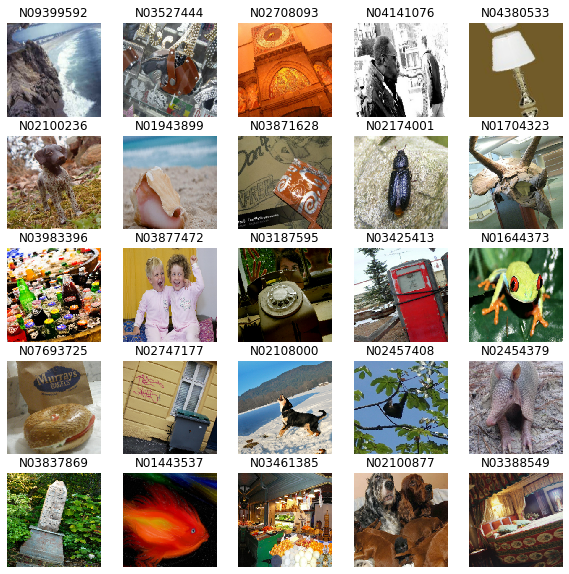

In [14]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

In [15]:
modelDiagramFile = os.path.join(resultsDir, 'model_densenet_imagenet_v1.png')

base_model = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), weights=None, include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

#keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)
#model.summary()

## Train model

In [16]:
from utils import learning_rate

learning_rate = learning_rate.PiecewiseConstantDecayWithWarmup(
        batch_size=BATCH_SIZE,
        epoch_size=TRAIN_EXAMPLES,
        warmup_epochs=5,
        boundaries=[30, 60, 80],
        multipliers=[1.0, 0.1, 0.01, 0.001])

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                    momentum=0.9,
                                    nesterov= None)

In [18]:
loss_obj = tf.keras.losses.CategoricalCrossentropy(
          label_smoothing=0.1)

In [19]:
metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
         tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]

In [20]:
model.compile(optimizer=optimizer,
              loss=loss_obj,
              metrics=metrics)

In [21]:
#from utils.callbacks import CustomTensorBoard
from utils import keras_utils

logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)

#tb_callback = CustomTensorBoard(log_dir=logsCheckDir,
#                                track_lr=True,
#                                initial_step=0,
#                                write_images=False)

perf_callback = keras_utils.TimeHistory(BATCH_SIZE,
                                        LOG_STEPS,
                                        logdir=logsCheckDir+'/metrics')

callbacks = [tb_callback, perf_callback]

In [ ]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          steps_per_epoch=TRAIN_STEPS,
          initial_epoch=0,
          callbacks=callbacks,
          validation_data=valDS,
          validation_steps=VAL_STEPS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Epoch 1/50
 3655/20018 [====>.........................] - ETA: 2:04:53 - loss: 6.8882 - accuracy: 0.0043 - top_5_accuracy: 0.0162

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12523/20018 [=================>............] - ETA: 59:12 - loss: 6.4166 - accuracy: 0.0226 - top_5_accuracy: 0.0700

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20018/20018 [==============================] - 9676s 483ms/step - loss: 6.0206 - accuracy: 0.0500 - top_5_accuracy: 0.1344 - val_loss: 5.7911 - val_accuracy: 0.0662 - val_top_5_accuracy: 0.1750
Epoch 2/50
  704/20018 [>.............................] - ETA: 2:16:01 - loss: 4.9591 - accuracy: 0.1422 - top_5_accuracy: 0.3300

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9369/20018 [=============>................] - ETA: 1:23:47 - loss: 4.6187 - accuracy: 0.1920 - top_5_accuracy: 0.4084

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18218/20018 [==========================>...] - ETA: 14:10 - loss: 4.3408 - accuracy: 0.2388 - top_5_accuracy: 0.4721

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12777/20018 [==================>...........] - ETA: 56:28 - loss: 3.5797 - accuracy: 0.3790 - top_5_accuracy: 0.6423

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18605/20018 [==========================>...] - ETA: 11:03 - loss: 3.5053 - accuracy: 0.3944 - top_5_accuracy: 0.6575

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8326/20018 [===========>..................] - ETA: 1:31:23 - loss: 3.1806 - accuracy: 0.4631 - top_5_accuracy: 0.7229

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20018/20018 [==============================] - 9575s 478ms/step - loss: 3.0935 - accuracy: 0.4821 - top_5_accuracy: 0.7397 - val_loss: 3.4216 - val_accuracy: 0.4153 - val_top_5_accuracy: 0.6786
Epoch 5/50
 1316/20018 [>.............................] - ETA: 2:11:31 - loss: 2.9501 - accuracy: 0.5132 - top_5_accuracy: 0.7666

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20018/20018 [==============================] - 9576s 478ms/step - loss: 2.8505 - accuracy: 0.5363 - top_5_accuracy: 0.7854 - val_loss: 3.1187 - val_accuracy: 0.4764 - val_top_5_accuracy: 0.7349
Epoch 6/50
13737/20018 [===================>..........] - ETA: 49:21 - loss: 2.6865 - accuracy: 0.5749 - top_5_accuracy: 0.8145

## Save model

In [ ]:
modelFile = os.path.join(modelsDir, 'model_densenet169.h5')

model.save(modelFile)

## Plot confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
y_pred=np.argmax(model.predict(testX), axis=1)
y_true=np.argmax(testY, axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=CLASS_NAMES,
                      title='Confusion matrix, without normalization')